### Torch implementation (acts like dir sampler)

In [71]:
import torch
import matplotlib.pyplot as plt
def sample_continuous_bernoulli(lmbda): 
    u=torch.rand(1).item()
    return u if torch.isclose(lmbda.detach().clone(),torch.tensor(1.0)) else torch.log(u*(lmbda-1)+1)/torch.log(lmbda.detach().clone())

def sample_cc_rejection(lambdas,max_trials=10000): 
    if lambdas.dim()==1: lambdas=lambdas.unsqueeze(0)
    batch_size,K=lambdas.shape
    out=[]
    for b in range(batch_size):
        lmb=lambdas[b]
        order=torch.argsort(-lmb,dim=0)
        l_sorted=lmb[order]
        for _ in range(max_trials): 
            x=torch.zeros(K)
            c=0.0
            i=1
            while c<1 and i<K: 
                theta=l_sorted[i]/(l_sorted[i]+l_sorted[0])
                x[i]=sample_continuous_bernoulli(theta)
                c+=x[i].item()
                i+=1
                if c<=1: 
                    x[0]=1-torch.sum(x[1:])
                    x=x[torch.argsort(order)]
                    out.append(x)
                    break
            if len(out)==b+1: break
        else: raise RuntimeError("Sampler failed to converge")
    return torch.stack(out)

def sample_cc_permutation(lambdas,max_trials=10000): 
    if lambdas.dim()==1: lambdas=lambdas.unsqueeze(0)
    batch_size,K=lambdas.shape
    out=[]
    for b in range(batch_size):
        eta=torch.log(lambdas[b])
        B=torch.tensor([[1.0,0.0],[1.0,1.0]])
        Binv=torch.inverse(B)
        etatilde=torch.inverse(B.T)@eta[:2]
        for _ in range(max_trials): 
            lam_tilde=torch.exp(etatilde)
            y0=torch.tensor([sample_continuous_bernoulli(l.item()) for l in lam_tilde])
            P=torch.argsort(y0); y=torch.sort(y0).values
            accept=True
            if accept: 
                x=Binv@y
                out.append(x)
                break
        else: raise RuntimeError("Sampler failed to converge")
    return torch.stack(out)


def cc_pdf(x1, x2, lambdas):
    l1, l2, l3 = lambdas
    mask = (x1 >= 0) & (x2 >= 0) & (x1 + x2 <= 1)
    vals = torch.zeros_like(x1)
    vals[mask] = (l1 ** x1[mask]) * (l2 ** x2[mask]) * (l3 ** (1 - x1[mask] - x2[mask]))
    return vals

In [73]:
sample_cc_rejection(torch.tensor([0.5,0.2,0.3]))

tensor([[0.6307, 0.0000, 0.3693]])

### Numpy implementation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sample_continuous_bernoulli(lmbda):
    """Sample from CB(λ), λ ∈ (0,1), via inverse CDF."""
    u = np.random.rand()
    if np.isclose(lmbda, 1.0):
        return u
    return np.log(u * (lmbda - 1) + 1) / np.log(lmbda)


def sample_cc_rejection(lambdas, max_trials=10000):
    """Ordered rejection sampler for Continuous Categorical CC(λ)."""
    lambdas = np.asarray(lambdas)
    K = len(lambdas)
    order = np.argsort(-lambdas)
    l_sorted = lambdas[order]

    for _ in range(max_trials):
        x = np.zeros(K)
        c = 0.0
        i = 1
        while c < 1 and i < K:
            theta = l_sorted[i] / (l_sorted[i] + l_sorted[0])
            x[i] = sample_continuous_bernoulli(theta)
            c += x[i]
            i += 1
        if c <= 1:
            x[0] = 1 - np.sum(x[1:])
            x = x[np.argsort(order)]
            return x
    raise RuntimeError("Sampler failed to converge")

# ---------- CC Permutation Sampler (Algorithm 2) ----------
def sample_cc_permutation(lambdas, max_trials=10000):
    """Permutation sampler (Algorithm 2) for Continuous Categorical (K=3)."""
    lambdas = np.asarray(lambdas)
    eta = np.log(lambdas)
    # Lower-triangular ones matrix B and its inverse
    B = np.array([[1.0, 0.0],
                  [1.0, 1.0]])
    Binv = np.linalg.inv(B)
    etatilde = np.linalg.inv(B.T) @ eta[:2]  # B^{-T} η

    for _ in range(max_trials):
        # Step 1: draw y0 ∈ [0,1]^2 i.i.d CB variates with parameter σ(etatilde)
        # Convert η~ to λ~ = exp(η~)
        lam_tilde = np.exp(etatilde)
        y0 = np.array([sample_continuous_bernoulli(l) for l in lam_tilde])

        # Step 2: sort into ascending order
        P = np.argsort(y0)
        y = np.sort(y0)

        # Step 3: acceptance probability α(y, η~, P)
        # For simplicity (demo), assume α≈1 (high acceptance for balanced λ)
        # Otherwise could compute relative ratios numerically
        accept = True

        if accept:
            x = Binv @ y
            return x
    raise RuntimeError("Sampler failed to converge")


def cc_pdf(x1, x2, lambdas):
    l1, l2, l3 = lambdas
    mask = (x1 >= 0) & (x2 >= 0) & (x1 + x2 <= 1)
    vals = np.zeros_like(x1)
    vals[mask] = (l1 ** x1[mask]) * (l2 ** x2[mask]) * (l3 ** (1 - x1[mask] - x2[mask]))
    return vals

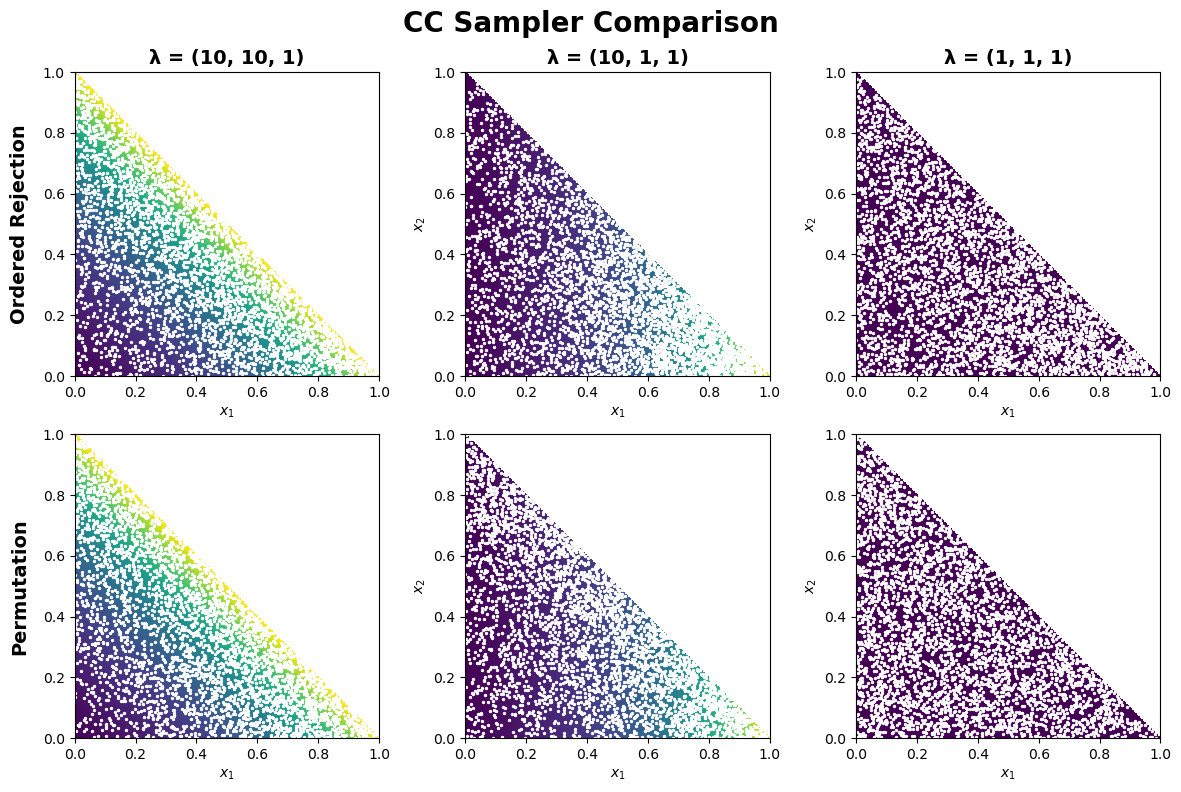

In [64]:
def compare_samplers():
    lambda_sets = [
        np.array([10.0, 10.0, 1.0]),
        np.array([10.0, 1.0, 1.0]),
        np.array([1.0, 1.0, 1.0]),
    ]
    column_titles = [
        "λ = (10, 10, 1)",
        "λ = (10, 1, 1)",
        "λ = (1, 1, 1)",
    ]
    row_titles = ["Ordered Rejection", "Permutation"]

    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    grid_n = 200
    xx, yy = np.meshgrid(np.linspace(0, 1, grid_n), np.linspace(0, 1, grid_n))

    for col, lambdas in enumerate(lambda_sets):
        pdf_vals = cc_pdf(xx, yy, lambdas)
        pdf_vals[(xx + yy) > 1] = np.nan
        N = 4000

        # --- Top row: Ordered Rejection Sampler ---
        samples_ord = np.array([sample_cc_rejection(lambdas) for _ in range(N)])
        x1_ord, x2_ord = samples_ord[:, 0], samples_ord[:, 1]
        ax = axes[0, col]
        ax.pcolormesh(xx, yy, pdf_vals, shading='auto', cmap='viridis')
        ax.scatter(x1_ord, x2_ord, s=2, c='white')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_aspect('equal', 'box')
        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")
        if col == 0:
            ax.set_ylabel(f"{row_titles[0]}", rotation=90, labelpad=10, fontsize=14,weight="bold")
        ax.set_title(column_titles[col], fontsize=14,weight="bold")

        # --- Bottom row: Permutation Sampler ---
        samples_perm = np.array([sample_cc_permutation(lambdas) for _ in range(N)])
        x1_perm, x2_perm = samples_perm[:, 0], samples_perm[:, 1]
        ax = axes[1, col]
        ax.pcolormesh(xx, yy, pdf_vals, shading='auto', cmap='viridis')
        ax.scatter(x1_perm, x2_perm, s=2, c='white')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.set_aspect('equal', 'box')
        ax.set_xlabel("$x_1$")
        ax.set_ylabel("$x_2$")
        if col == 0:
            ax.set_ylabel(f"{row_titles[1]}", rotation=90, labelpad=10, fontsize=14,weight="bold")

    plt.suptitle("CC Sampler Comparison", fontsize=20,weight="bold")
    plt.tight_layout()
    plt.savefig("reports/figures/cc_sampler_comparison.svg")
    plt.show()


# ---------- Run ----------
compare_samplers()